In [38]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

# PyTorch
import torch
import torch_scatter
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import global_mean_pool, global_max_pool, global_add_pool
import torch.nn.functional as F

# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

# cust_functions folder
from cust_functions.training import *
from cust_functions.graph_networks import *
from cust_functions.graph_creation import *

In [39]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [40]:
# Load data
input_data = pd.read_csv("aki_data/test_data.tsv", sep="\t", )
input_data_qm = pd.read_csv("aki_data/test_qm.csv")
translation = pd.read_csv("aki_data/translation.tsv", sep="\t", index_col=0)
pathways = pd.read_csv("aki_data/pathways.tsv", sep="\t")
design_matrix = pd.read_csv("aki_data/design_matrix.tsv", sep="\t")

# Preprocess input data
input_data_preprocessed = input_data_qm.fillna(0)
design_matrix = design_matrix.replace(1, 0)
design_matrix = design_matrix.replace(2, 1)

Number of nodes:  2585
Number of edges:  2603
Number of nodes with no edges:  0
Mean number of edges per node:  2.0
Max number of edges per node:  72
Min number of edges per node:  1
Median number of edges per node:  1.0
Number of nodes without proteins:  424


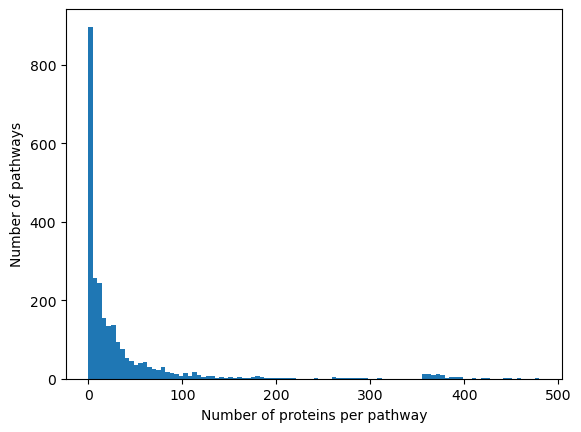

In [41]:
# Initialize graph
G = create_pathway_graph(pathways, translation, descendants=True)

print("Number of nodes: ", len(G.nodes))
print("Number of edges: ", len(G.edges))
print("Number of nodes with no edges: ", len([n for n in G.nodes if G.degree(n)==0]))
print("Mean number of edges per node: ", np.round(np.mean([G.degree(n) for n in G.nodes]),1))
print("Max number of edges per node: ", np.max([G.degree(n) for n in G.nodes]))
print("Min number of edges per node: ", np.min([G.degree(n) for n in G.nodes]))
print("Median number of edges per node: ", np.median([G.degree(n) for n in G.nodes]))
print("Number of nodes without proteins: ", len([n for n in G.nodes if len(G.nodes[n].get('proteins', '') )==0]))

# collect number of proteins per pathway
num_proteins_per_pathway = [len(G.nodes[node].get('proteins', '')) for node in G.nodes()]
plt.hist(num_proteins_per_pathway, bins=100)
plt.xlabel("Number of proteins per pathway")
plt.ylabel("Number of pathways")
plt.show()


In [42]:
# Initialize validation
FOLDS = 3
train_labels = design_matrix['group'][design_matrix['sample'].str.contains('M2012')]
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

## 2.0 Model pipelines

### 2.1 Baseline model

In [8]:
train_graph_data, test_graph_data = [], []
patient_ids = design_matrix['sample'].values

for patient_id in patient_ids:
    graph = G.copy()

    # Add abundance to graph
    for _, row in input_data_preprocessed.iterrows():
        protein = row['Protein']  
        abundance = row[patient_id] 
        for pathway in graph.nodes:
            if 'proteins' in graph.nodes[pathway] and protein in graph.nodes[pathway]['proteins']:
                if 'abundance' not in graph.nodes[pathway]:
                    graph.nodes[pathway]['abundance'] = 0
                graph.nodes[pathway]['abundance'] += abundance
    
    # Convert NetworkX graph to PyTorch Geometric Data
    edge_index = map_edges_to_indices(graph.edges)
    x = torch.tensor([graph.nodes[node].get('abundance', 0) for node in graph.nodes], dtype=torch.float).unsqueeze(1)
    y = torch.tensor([design_matrix[design_matrix['sample'] == patient_id]['group'].iloc[0]], dtype=torch.long)
    graph_data = Data(x=x, edge_index=edge_index, y=y)

    if 'M2012' in patient_id:
        train_graph_data.append(graph_data)
    else:
        test_graph_data.append(graph_data)

In [11]:
print(f"Number of training graphs: {len(train_graph_data)}")
print(f"Number of test graphs: {len(test_graph_data)}")
print(f"Number of features: {train_graph_data[0].num_features}")
print(f"Number of classes: {np.unique([graph.y.detach().numpy()[0] for graph in train_graph_data])}")
print(f"Is directed: {train_graph_data[0].is_directed()}")
print(train_graph_data[0])

Number of training graphs: 141
Number of test graphs: 56
Number of features: 1
Number of classes: [0 1]
Is directed: True
Data(x=[2585, 1], edge_index=[2, 2603], y=[1])


In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.001
weight_decay = 0.0001
batch_size = 32
layer_configs = [
    {"in_channels": 128, "out_channels": 64, "dropout_rate": 0.1, "batch_norm": True, "residual": True},
    {"in_channels": 64, "out_channels": 64, "dropout_rate": 0.1, "batch_norm": True, "residual": True},
]

loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 100

# Initialize results dictionary
results = {}


for fold, (train_idx, test_idx) in enumerate(skf.split(train_graph_data, train_labels)):
    
    # Initialize fold results
    print(f"Fold: {fold + 1}")
    train_loader = DataLoader([train_graph_data[i] for i in train_idx], batch_size=batch_size)
    val_loader = DataLoader([train_graph_data[i] for i in test_idx], batch_size=batch_size)

    # Initialize model
    model = ResGCN(train_graph_data[0].num_features, layer_configs, 2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5, verbose=True)

    # Initialize early stopping
    best_val_loss = np.inf
    best_roc_auc = 0
    best_model = None
    patience = 30
    

    for epoch in range(num_epochs):
        
        # Train and validate
        train_loss, train_confusion_matrix = train(train_loader, model, optimizer, loss_fn, device, update_confusion_matrix=True)
        val_loss, val_confusion_matrix = validate(val_loader, model, loss_fn, device, update_confusion_matrix=True)

        # update results
        results = update_results(results, fold, epoch, train_loss, train_confusion_matrix, val_loss, val_confusion_matrix)
        
        # Early stopping 
        if results[fold + 1]['val_roc_auc'][-1] > best_roc_auc:
            best_roc_auc = results[fold + 1]['val_roc_auc'][-1]
            best_val_epoch = epoch + 1
            results[fold + 1]['best_val_epoch'] = best_val_epoch
            best_model = model.state_dict().copy()
            patience = 30
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
        # print epoch results
        print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {results[fold + 1]['train_accuracy'][-1]:.4f}")
        print(f"Epoch: {epoch + 1}, Val Loss: {val_loss:.4f}, Val Acc: {results[fold + 1]['val_accuracy'][-1]:.4f}, Val ROC_AUC: {results[fold + 1]['val_roc_auc'][-1]:.4f}, Val F1 Phen1: {results[fold + 1]['val_f1_phen1'][-1]:.4f}, Val F1 Phen2: {results[fold + 1]['val_f1_phen2'][-1]:.4f}")

        # update learning rate
        scheduler.step(val_loss)
        
    # save best model for fold
    model.load_state_dict(best_model)
    PATH = f"trained_models/Baseline_model_fold_{fold + 1}_rocauc_{np.round(best_roc_auc, 2)}.pt"
    torch.save(model.state_dict(), PATH)


Using device: cuda
Fold: 1
Epoch: 1, Train Loss: 0.7160, Train Acc: 0.5638
Epoch: 1, Val Loss: 0.6784, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 2, Train Loss: 0.7178, Train Acc: 0.5426
Epoch: 2, Val Loss: 0.6826, Val Acc: 0.6170, Val ROC_AUC: 0.5500, Val F1 Phen1: 0.7500, Val F1 Phen2: 0.1818
Epoch: 3, Train Loss: 0.6936, Train Acc: 0.5319
Epoch: 3, Val Loss: 0.6820, Val Acc: 0.6170, Val ROC_AUC: 0.5500, Val F1 Phen1: 0.7500, Val F1 Phen2: 0.1818
Epoch: 4, Train Loss: 0.7113, Train Acc: 0.5426
Epoch: 4, Val Loss: 0.6804, Val Acc: 0.6170, Val ROC_AUC: 0.5500, Val F1 Phen1: 0.7500, Val F1 Phen2: 0.1818
Epoch: 5, Train Loss: 0.7325, Train Acc: 0.5106
Epoch: 5, Val Loss: 0.6789, Val Acc: 0.6170, Val ROC_AUC: 0.5500, Val F1 Phen1: 0.7500, Val F1 Phen2: 0.1818
Epoch: 6, Train Loss: 0.6929, Train Acc: 0.5426
Epoch: 6, Val Loss: 0.6782, Val Acc: 0.6170, Val ROC_AUC: 0.5500, Val F1 Phen1: 0.7500, Val F1 Phen2: 0.1818
Epoch: 7, Train Loss: 0.6701, T

Average validation accuracy: 0.695 +/- 0.04
Average validation ROC_AUC: 0.709 +/- 0.04
Average validation F1 Phen1: 0.696 +/- 0.06
Average validation F1 Phen2: 0.692 +/- 0.03


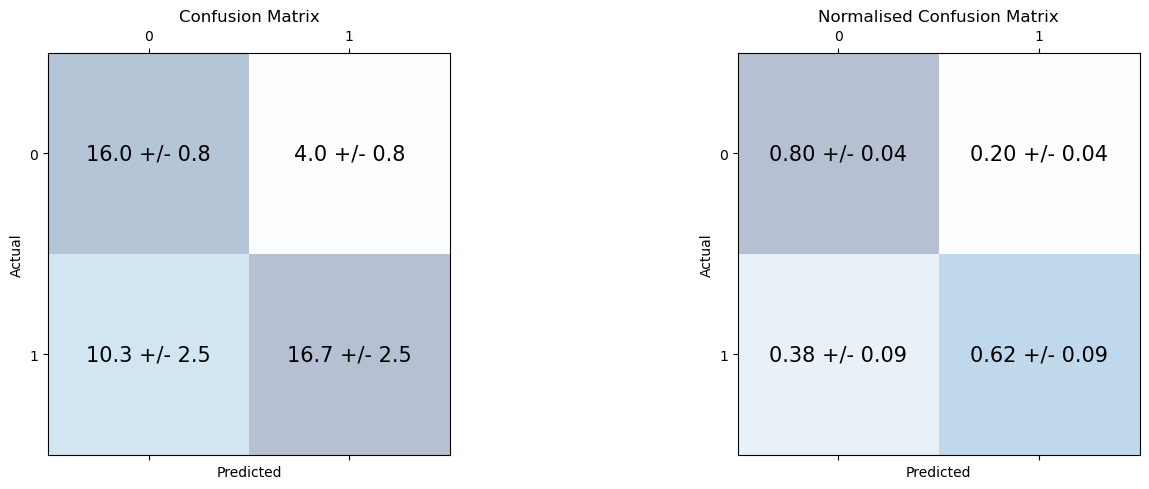

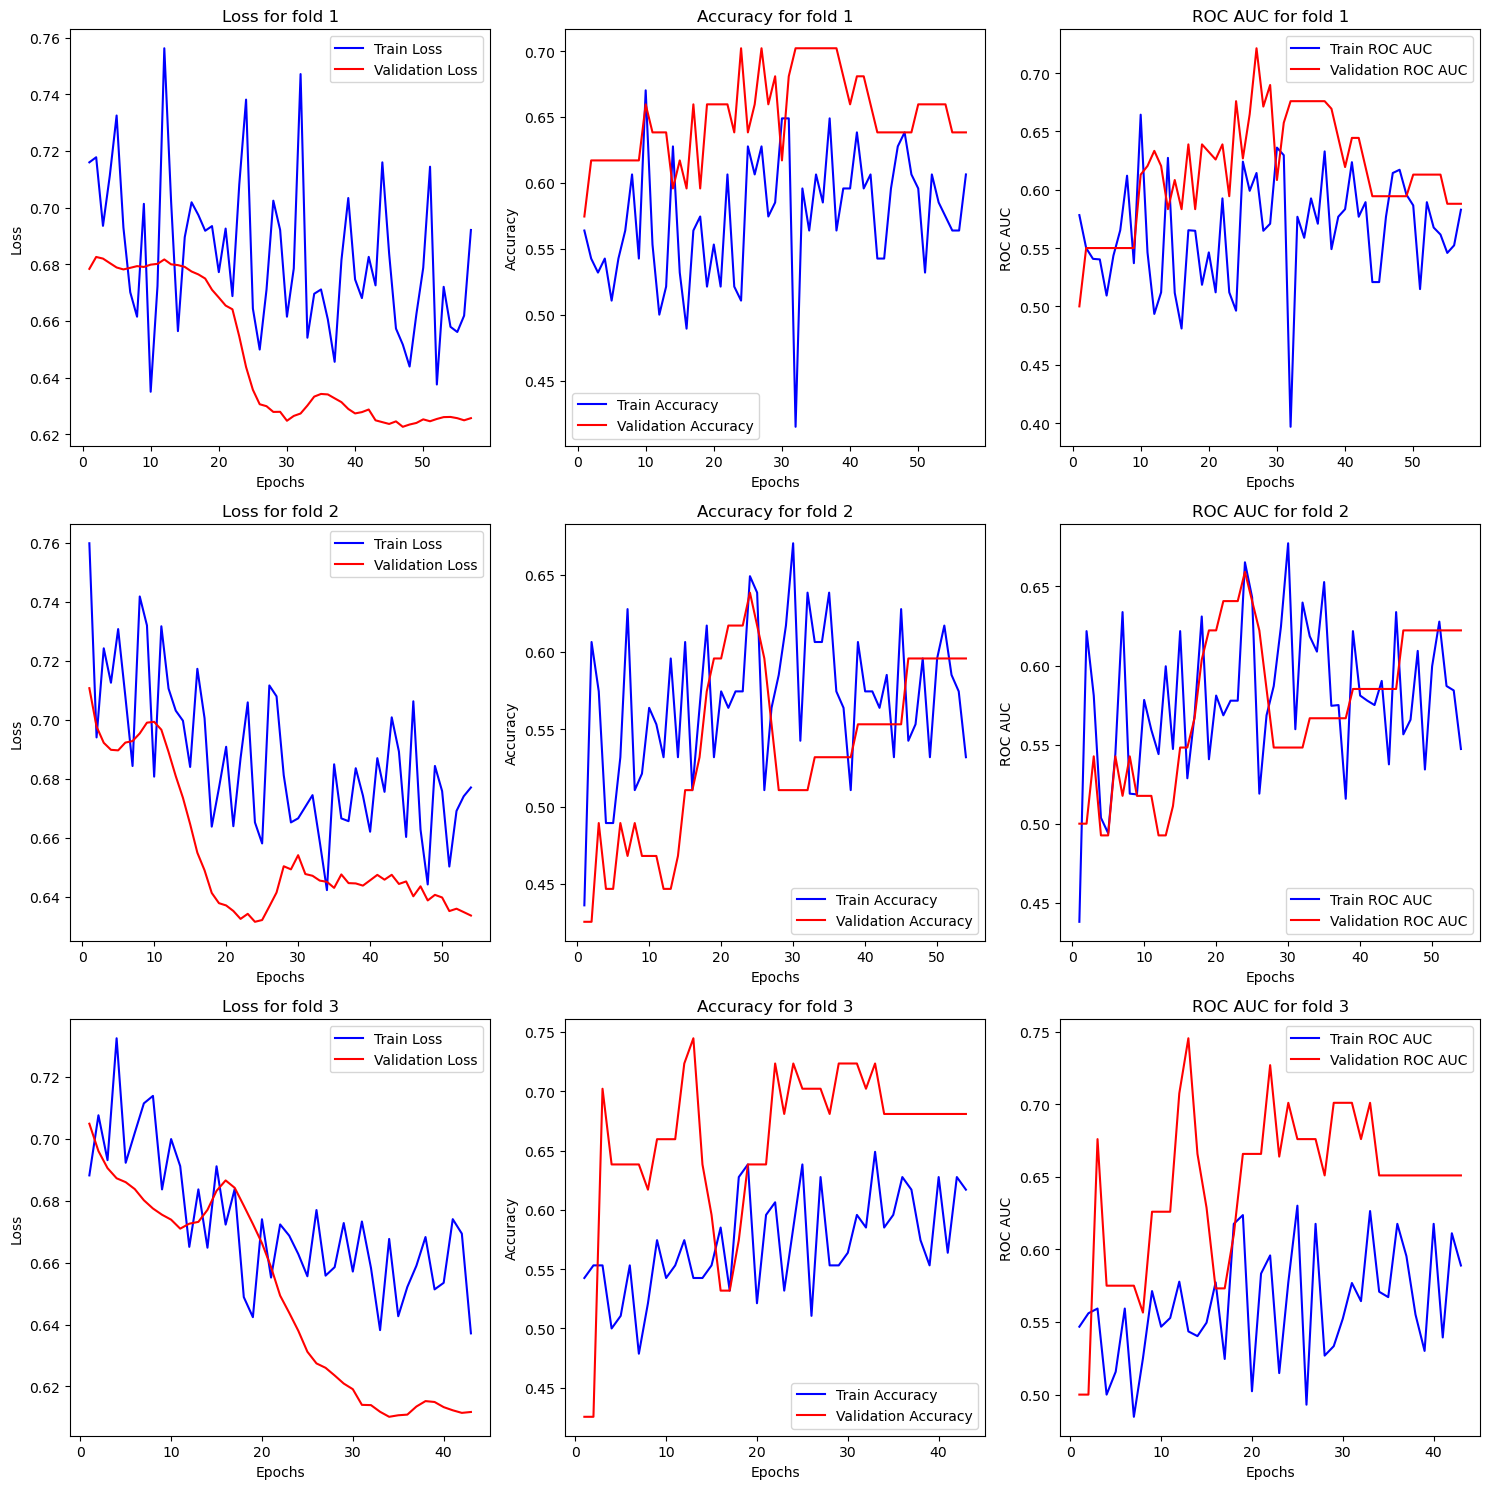

In [81]:
print_val_results(results)
plot_confusion_matrix(results)
plot_results(results, FOLDS)

### 2.2 With PCA

In [6]:
patient_ids = design_matrix['sample'].values
protein_names = input_data_preprocessed['Protein'].tolist()

# Dictionary to store PCA models for each patient
pca_models = {}

# Dictionary to store feature vectors for each patient
patient_features = {patient_id: [] for patient_id in patient_ids}

# Initialize a feature matrix for each pathway per patient
for patient_id in patient_ids:
    pathway_features = np.zeros((len(G.nodes()), len(protein_names)))
    for i, pathway in enumerate(G.nodes()):
        proteins_in_pathway = G.nodes[pathway].get('proteins', [])
        for j, protein in enumerate(protein_names):
            if protein in proteins_in_pathway:
                pathway_features[i, j] = input_data_preprocessed.loc[input_data_preprocessed['Protein'] == protein, patient_id].values[0]
    
    # Apply PCA to the pathway features for this patient
    pca = PCA(n_components=40)  # Or however many components you wish to retain
    pca_features = pca.fit_transform(pathway_features)
    pca_models[patient_id] = pca  # Store the fitted PCA model
    patient_features[patient_id] = pca_features  # Store the PCA-reduced features


In [7]:
train_graph_data, test_graph_data = [], []

for patient_id in patient_ids:
    graph = G.copy()

    # Get the PCA-reduced features for this patient
    features = patient_features[patient_id]

    # Convert NetworkX graph to PyTorch Geometric Data
    edge_index = map_edges_to_indices(graph.edges)
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor([design_matrix[design_matrix['sample'] == patient_id]['group'].iloc[0]], dtype=torch.long)
    graph_data = Data(x=x, edge_index=edge_index, y=y)

    if 'M2012' in patient_id:
        train_graph_data.append(graph_data)
    else:
        test_graph_data.append(graph_data)

In [8]:
print(f"Number of training graphs: {len(train_graph_data)}")
print(f"Number of test graphs: {len(test_graph_data)}")
print(f"Number of features: {train_graph_data[0].num_features}")
print(f"Number of classes: {np.unique([graph.y.detach().numpy()[0] for graph in train_graph_data])}")
print(f"Is directed: {train_graph_data[0].is_directed()}")
print(train_graph_data[0])

Number of training graphs: 141
Number of test graphs: 56
Number of features: 40
Number of classes: [0 1]
Is directed: True
Data(x=[2585, 40], edge_index=[2, 2603], y=[1])


In [37]:
class SAGE_LSTM(torch.nn.Module):
    def __init__(self, num_features, layer_configs, num_classes):
        super(SAGE_LSTM, self).__init__()

        initial_layer = layer_configs[0]
        self.initial = SAGEBlock(num_features, initial_layer['out_channels'], initial_layer['dropout_rate'], initial_layer['batch_norm'])

        self.hidden_layers = torch.nn.ModuleList()
        for layer_config in layer_configs[1:]:
            self.hidden_layers.append(SAGEBlock(layer_config['in_channels'], layer_config['out_channels'], layer_config['dropout_rate'], layer_config['batch_norm']))

        self.lstm_pooling = LSTM(input_size=layer_configs[-1]['out_channels'], hidden_size=16, batch_first=True)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(16, num_classes),
        )

    def forward(self, x, edge_index, batch):
        x = self.initial(x, edge_index)
        for layer in self.hidden_layers:
            x = layer(x, edge_index)

        # Process each graph in the batch individually and use LSTM on its nodes
        pooled_outputs = []
        for graph_id in batch.unique():
            # Extract nodes for this graph
            nodes_for_graph = x[batch == graph_id]

            # Add an extra dimension for batch (LSTM expects 3D input: batch x seq x feature)
            nodes_for_graph = nodes_for_graph.unsqueeze(0)

            # LSTM pooling
            out, (hn, cn) = self.lstm_pooling(nodes_for_graph)

            # Use the last LSTM output for this graph as its pooled representation
            pooled_representation = out[0, -1, :]
            pooled_outputs.append(pooled_representation)

        # Concatenate pooled representations for all graphs to match batch size
        x_pooled = torch.stack(pooled_outputs)

        x = self.mlp(x_pooled)
        return x

In [9]:
class ResGCN(torch.nn.Module):
    def __init__(self, num_features, layer_configs, num_classes):
        super(ResGCN, self).__init__()

        initial_layer = layer_configs[0]
        self.initial = GCNBlock(num_features, initial_layer['out_channels'], initial_layer['dropout_rate'], initial_layer['batch_norm'])

        self.hidden_layers = torch.nn.ModuleList()
        for layer_config in layer_configs[1:]:
            self.hidden_layers.append(GCNBlock(layer_config['in_channels'], layer_config['out_channels'], layer_config['dropout_rate'], layer_config['batch_norm'], residual=True))

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(layer_configs[-1]['out_channels'], 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(64, num_classes),
        )

    def forward(self, x, edge_index, batch):
        x = self.initial(x, edge_index)
        for layer in self.hidden_layers:
            x = layer(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.mlp(x)
        return x


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.0005
weight_decay = 0.02
batch_size = 4
layer_configs = [
    {"in_channels": 128, "out_channels": 64, "dropout_rate": 0.7, "batch_norm": True, "residual": True},
    {"in_channels": 64, "out_channels": 32, "dropout_rate": 0.7, "batch_norm": True, "residual": True},
]

loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 100

# Initialize results dictionary
results = {}


for fold, (train_idx, test_idx) in enumerate(skf.split(train_graph_data, train_labels)):
    
    # Initialize fold results
    print(f"Fold: {fold + 1}")
    train_loader = DataLoader([train_graph_data[i] for i in train_idx], batch_size=batch_size)
    val_loader = DataLoader([train_graph_data[i] for i in test_idx], batch_size=batch_size)

    # Initialize model
    model = SAGE_LSTM(train_graph_data[0].num_features, layer_configs, 2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Initialize early stopping
    best_val_loss = np.inf
    best_model = None
    patience = 30
    

    for epoch in range(num_epochs):
        
        # Train and validate
        train_loss, train_confusion_matrix = train(train_loader, model, optimizer, loss_fn, device, update_confusion_matrix=True)
        val_loss, val_confusion_matrix = validate(val_loader, model, loss_fn, device, update_confusion_matrix=True)

        # update results
        results = update_results(results, fold, epoch, train_loss, train_confusion_matrix, val_loss, val_confusion_matrix)
        
        # Early stopping 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_epoch = epoch + 1
            results[fold + 1]['best_val_epoch'] = best_val_epoch
            best_model = model.state_dict().copy()
            patience = 30
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
        # print epoch results
        print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {results[fold + 1]['train_accuracy'][-1]:.4f}")
        print(f"Epoch: {epoch + 1}, Val Loss: {val_loss:.4f}, Val Acc: {results[fold + 1]['val_accuracy'][-1]:.4f}, Val ROC_AUC: {results[fold + 1]['val_roc_auc'][-1]:.4f}, Val F1 Phen1: {results[fold + 1]['val_f1_phen1'][-1]:.4f}, Val F1 Phen2: {results[fold + 1]['val_f1_phen2'][-1]:.4f}")

        # update learning rate
        scheduler.step(val_loss)
        
    # save best model for fold
    model.load_state_dict(best_model)
    best_roc_auc = results[fold + 1]['val_roc_auc'][best_val_epoch - 1]
    PATH = f"trained_models/PCA_model_fold_{fold + 1}_rocauc_{np.round(best_roc_auc, 2)}.pt"
    torch.save(model.state_dict(), PATH)

Using device: cuda
Fold: 1
Epoch: 1, Train Loss: 0.6933, Train Acc: 0.5745
Epoch: 1, Val Loss: 0.6885, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 2, Train Loss: 0.6850, Train Acc: 0.5745
Epoch: 2, Val Loss: 0.6868, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 3, Train Loss: 0.6843, Train Acc: 0.5745
Epoch: 3, Val Loss: 0.6858, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 4, Train Loss: 0.6833, Train Acc: 0.5745
Epoch: 4, Val Loss: 0.6850, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 5, Train Loss: 0.6824, Train Acc: 0.5745
Epoch: 5, Val Loss: 0.6842, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 6, Train Loss: 0.6822, Train Acc: 0.5745
Epoch: 6, Val Loss: 0.6835, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 7, Train Loss: 0.6811, T

Average validation accuracy: 0.695 +/- 0.12
Average validation ROC_AUC: 0.655 +/- 0.15
Average validation F1 Phen1: 0.785 +/- 0.06
Average validation F1 Phen2: 0.419 +/- 0.34


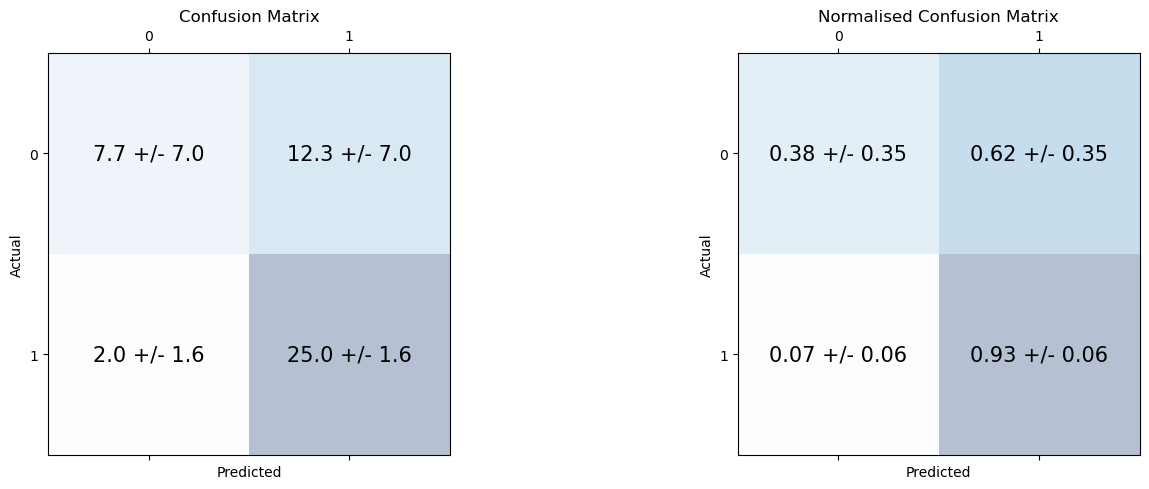

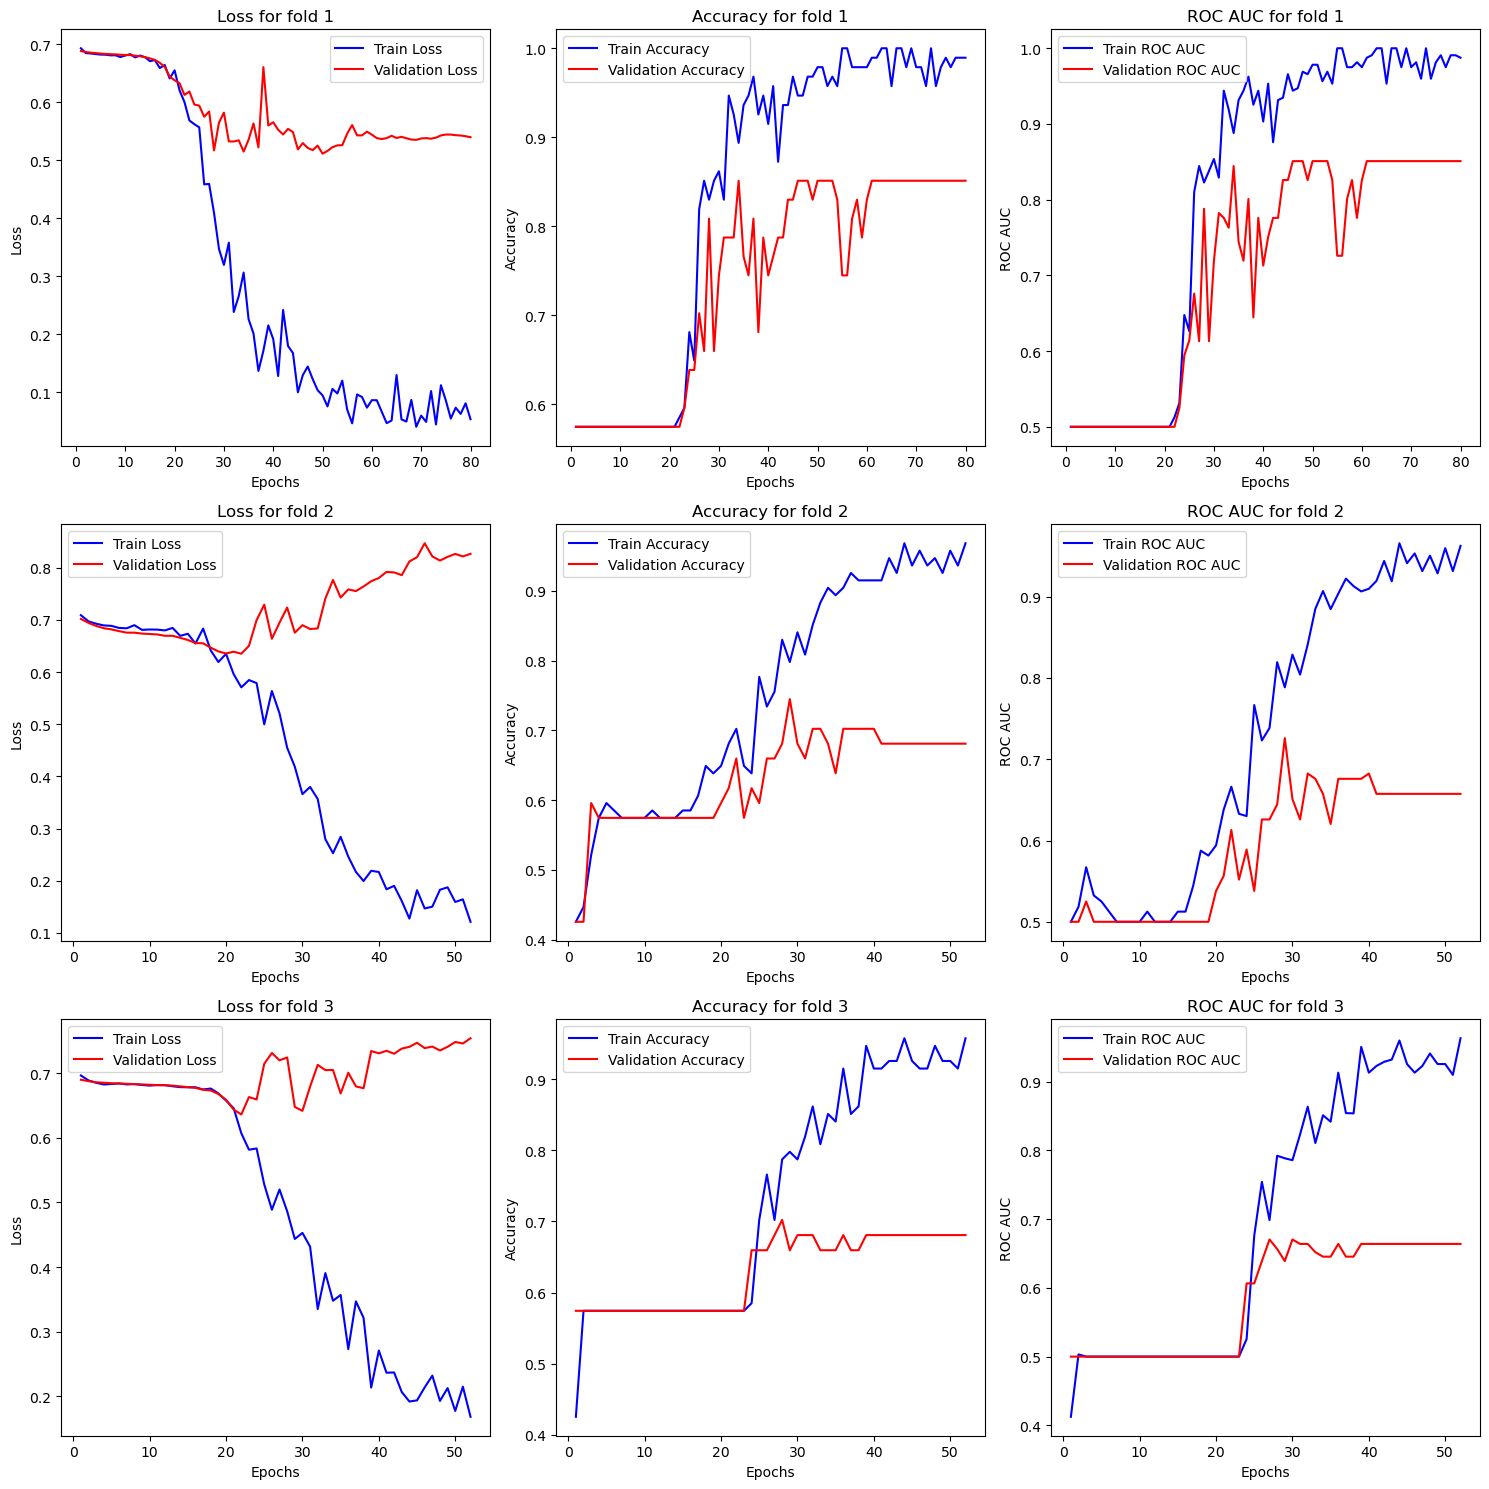

In [16]:
print_val_results(results)
plot_confusion_matrix(results)
plot_results(results, FOLDS)

### 2.3 All proteins as features

In [43]:
patient_ids = design_matrix['sample'].values
protein_names = input_data_preprocessed['Protein'].tolist()

# Dictionary to store feature vectors for each patient
patient_features = {patient_id: [] for patient_id in patient_ids}

# Initialize a feature matrix for each pathway per patient
for patient_id in patient_ids:
    pathway_features = np.zeros((len(G.nodes()), len(protein_names)))
    for i, pathway in enumerate(G.nodes()):
        proteins_in_pathway = G.nodes[pathway].get('proteins', [])
        for j, protein in enumerate(protein_names):
            if protein in proteins_in_pathway:
                pathway_features[i, j] = input_data_preprocessed.loc[input_data_preprocessed['Protein'] == protein, patient_id].values[0]

    patient_features[patient_id] = pathway_features  



In [44]:
train_graph_data, test_graph_data = [], []

for patient_id in patient_ids:
    graph = G.copy()

    # Get the PCA-reduced features for this patient
    features = patient_features[patient_id]

    # Convert NetworkX graph to PyTorch Geometric Data
    edge_index = map_edges_to_indices(graph.edges)
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor([design_matrix[design_matrix['sample'] == patient_id]['group'].iloc[0]], dtype=torch.long)
    graph_data = Data(x=x, edge_index=edge_index, y=y)

    if 'M2012' in patient_id:
        train_graph_data.append(graph_data)
    else:
        test_graph_data.append(graph_data)

In [45]:
print(f"Number of training graphs: {len(train_graph_data)}")
print(f"Number of test graphs: {len(test_graph_data)}")
print(f"Number of features: {train_graph_data[0].num_features}")
print(f"Number of classes: {np.unique([graph.y.detach().numpy()[0] for graph in train_graph_data])}")
print(f"Is directed: {train_graph_data[0].is_directed()}")
print(train_graph_data[0])

Number of training graphs: 141
Number of test graphs: 56
Number of features: 554
Number of classes: [0 1]
Is directed: True
Data(x=[2585, 554], edge_index=[2, 2603], y=[1])


In [46]:
class ResGCN(torch.nn.Module):
    def __init__(self, num_features, layer_configs, num_classes):
        super(ResGCN, self).__init__()

        initial_layer = layer_configs[0]
        self.initial = GCNBlock(num_features, initial_layer['out_channels'], initial_layer['dropout_rate'], initial_layer['batch_norm'])

        self.hidden_layers = torch.nn.ModuleList()
        for layer_config in layer_configs[1:]:
            self.hidden_layers.append(GCNBlock(layer_config['in_channels'], layer_config['out_channels'], layer_config['dropout_rate'], layer_config['batch_norm'], residual=True))

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(layer_configs[-1]['out_channels'], 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(64, num_classes),
        )

    def forward(self, x, edge_index, batch):
        x = self.initial(x, edge_index)
        for layer in self.hidden_layers:
            x = layer(x, edge_index)
        x = global_max_pool(x, batch)
        x = self.mlp(x)
        return x

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.001
weight_decay = 0.05
batch_size = 8
layer_configs = [
    {"in_channels": 32, "out_channels": 32, "dropout_rate": 0.6, "batch_norm": True, "residual": True},
]

loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 150

# Initialize results dictionary
results = {}


for fold, (train_idx, test_idx) in enumerate(skf.split(train_graph_data, train_labels)):
    
    # Initialize fold results
    print(f"Fold: {fold + 1}")
    train_loader = DataLoader([train_graph_data[i] for i in train_idx], batch_size=batch_size)
    val_loader = DataLoader([train_graph_data[i] for i in test_idx], batch_size=batch_size)

    # Initialize model
    model = ResGCN(train_graph_data[0].num_features, layer_configs, 2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Initialize early stopping
    best_val_loss = np.inf
    best_model = None
    patience = 30
    

    for epoch in range(num_epochs):
        
        # Train and validate
        train_loss, train_confusion_matrix = train(train_loader, model, optimizer, loss_fn, device, update_confusion_matrix=True)
        val_loss, val_confusion_matrix = validate(val_loader, model, loss_fn, device, update_confusion_matrix=True)

        # update results
        results = update_results(results, fold, epoch, train_loss, train_confusion_matrix, val_loss, val_confusion_matrix)
        
        # Early stopping 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_epoch = epoch + 1
            results[fold + 1]['best_val_epoch'] = best_val_epoch
            best_model = model.state_dict().copy()
            patience = 20
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
        # print epoch results
        print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {results[fold + 1]['train_accuracy'][-1]:.4f}")
        print(f"Epoch: {epoch + 1}, Val Loss: {val_loss:.4f}, Val Acc: {results[fold + 1]['val_accuracy'][-1]:.4f}, Val ROC_AUC: {results[fold + 1]['val_roc_auc'][-1]:.4f}, Val F1 Phen1: {results[fold + 1]['val_f1_phen1'][-1]:.4f}, Val F1 Phen2: {results[fold + 1]['val_f1_phen2'][-1]:.4f}")

        # update learning rate
        scheduler.step(val_loss)
        
    # save best model for fold
    model.load_state_dict(best_model)
    best_roc_auc = results[fold + 1]['val_roc_auc'][best_val_epoch - 1]
    PATH = f"trained_models/Full_model_ResGCN_fold_{fold + 1}_rocauc_{np.round(best_roc_auc, 2)}.pt"
    torch.save(model.state_dict(), PATH)

Using device: cuda
Fold: 1
Epoch: 1, Train Loss: 3.1186, Train Acc: 0.4149
Epoch: 1, Val Loss: 0.7215, Val Acc: 0.4043, Val ROC_AUC: 0.4361, Val F1 Phen1: 0.3000, Val F1 Phen2: 0.4815
Epoch: 2, Train Loss: 1.1692, Train Acc: 0.4362
Epoch: 2, Val Loss: 0.6810, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 3, Train Loss: 1.1057, Train Acc: 0.4894
Epoch: 3, Val Loss: 0.6661, Val Acc: 0.6383, Val ROC_AUC: 0.6074, Val F1 Phen1: 0.7213, Val F1 Phen2: 0.4848
Epoch: 4, Train Loss: 0.9831, Train Acc: 0.5745
Epoch: 4, Val Loss: 0.6501, Val Acc: 0.6170, Val ROC_AUC: 0.5630, Val F1 Phen1: 0.7353, Val F1 Phen2: 0.3077
Epoch: 5, Train Loss: 0.7874, Train Acc: 0.6383
Epoch: 5, Val Loss: 0.6518, Val Acc: 0.6383, Val ROC_AUC: 0.5880, Val F1 Phen1: 0.7463, Val F1 Phen2: 0.3704
Epoch: 6, Train Loss: 0.7441, Train Acc: 0.6277
Epoch: 6, Val Loss: 0.6175, Val Acc: 0.7021, Val ROC_AUC: 0.6694, Val F1 Phen1: 0.7742, Val F1 Phen2: 0.5625
Epoch: 7, Train Loss: 0.7346, T

Average validation accuracy: 0.872 +/- 0.0
Average validation ROC_AUC: 0.869 +/- 0.01
Average validation F1 Phen1: 0.889 +/- 0.0
Average validation F1 Phen2: 0.85 +/- 0.01


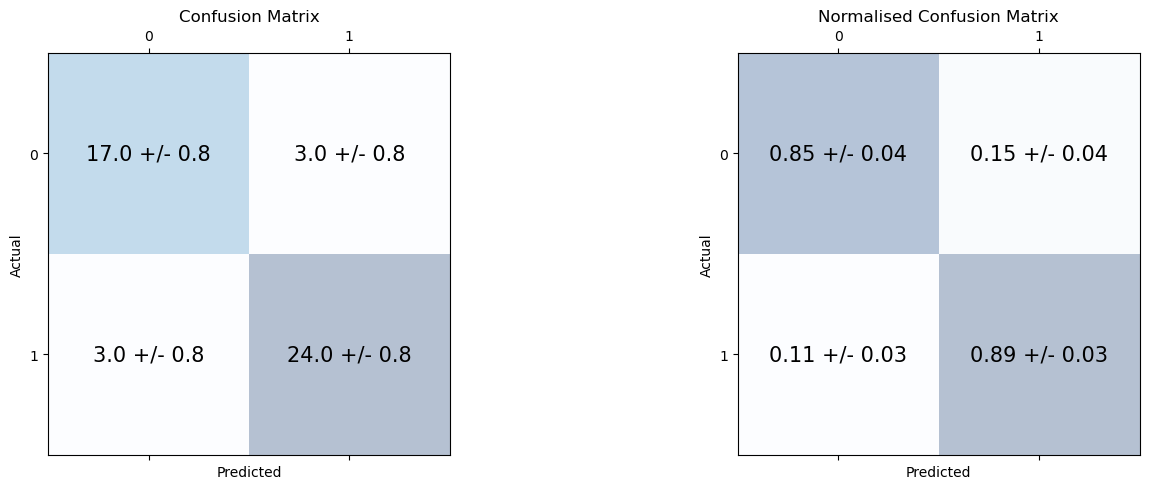

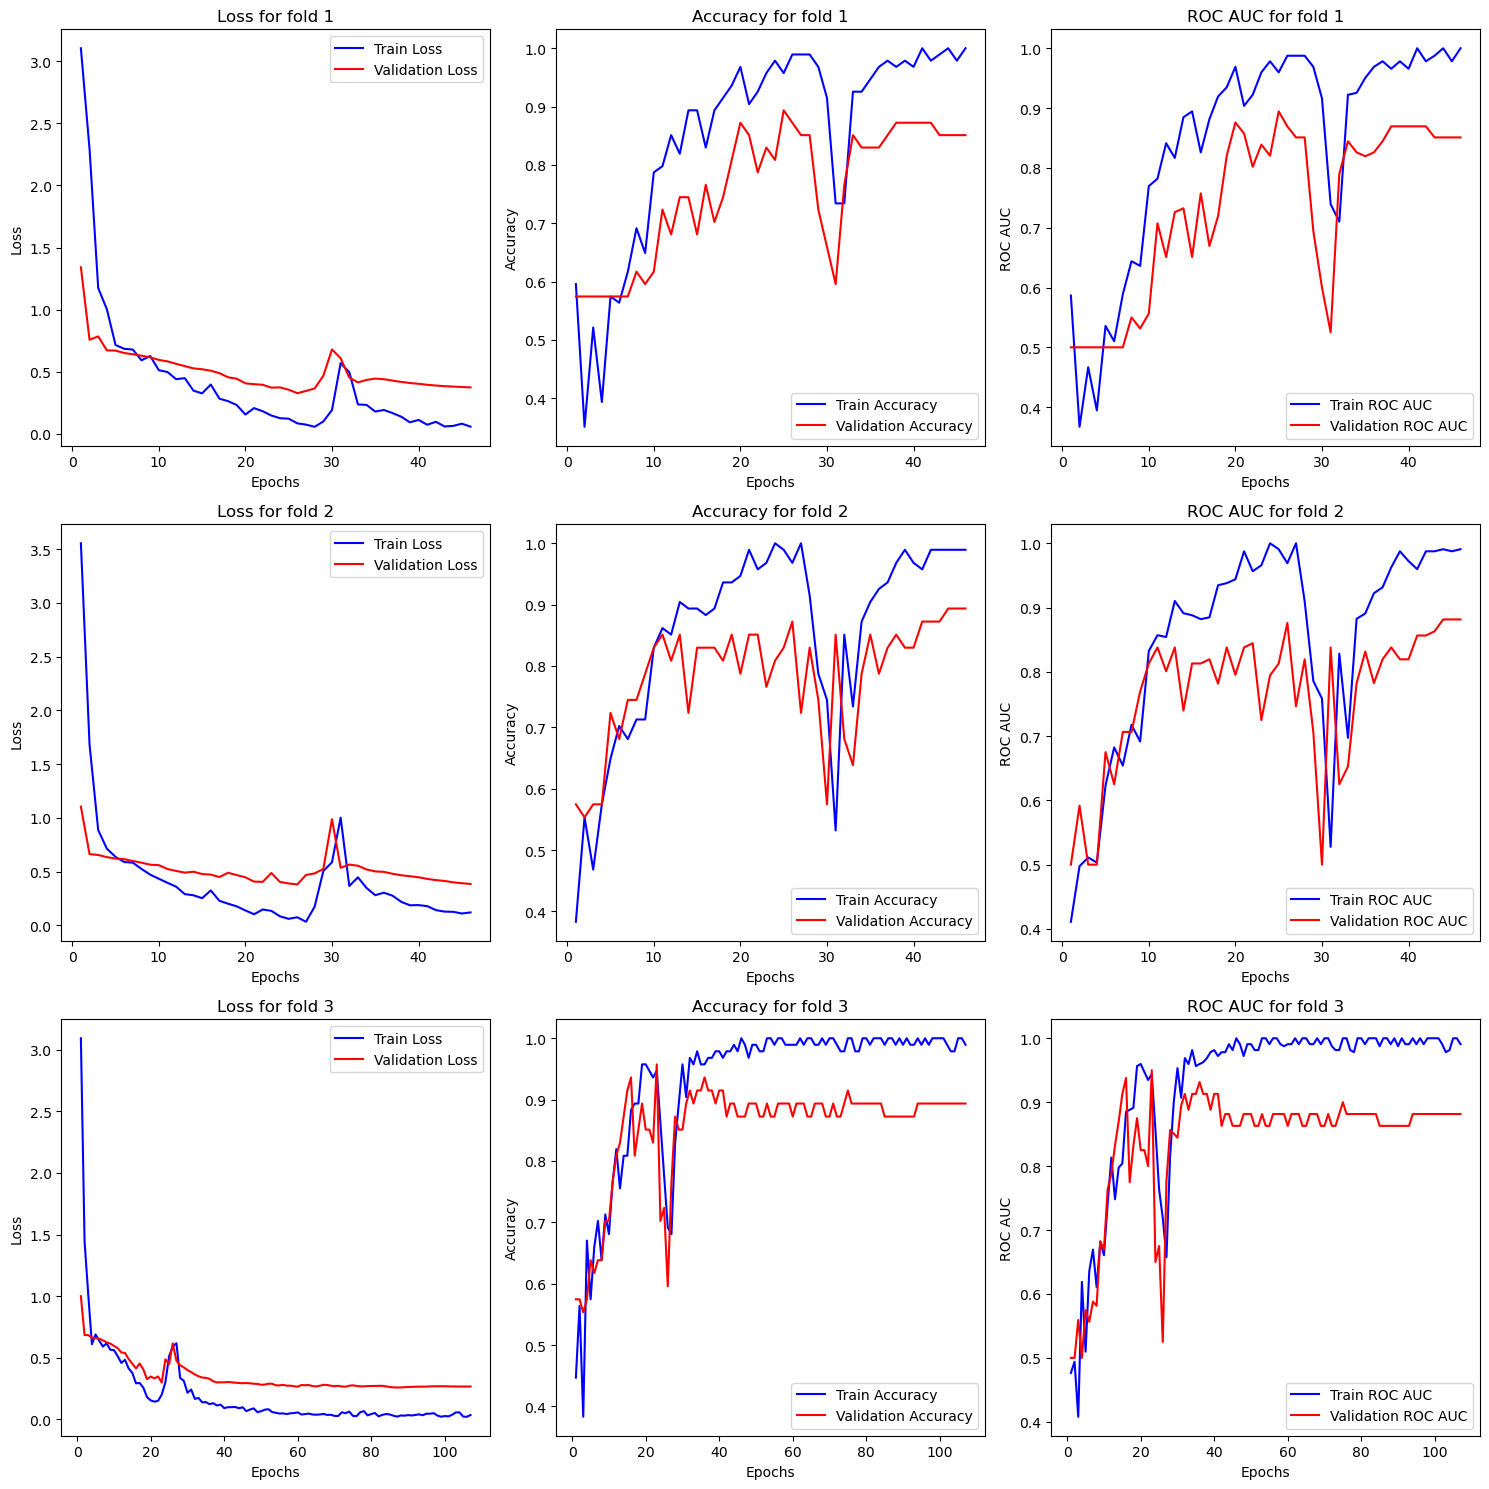

In [48]:
print_val_results(results)
plot_confusion_matrix(results)
plot_results(results, FOLDS)

In [49]:
# test data
test_loader = DataLoader(test_graph_data, batch_size=1)

# load all 3 folds
model_paths = ["trained_models/Full_model_ResGCN_fold_1_rocauc_0.87.pt", "trained_models/Full_model_ResGCN_fold_2_rocauc_0.88.pt", "trained_models/Full_model_ResGCN_fold_3_rocauc_0.86.pt"]
models = [ResGCN(train_graph_data[0].num_features, layer_configs, 2).to(device) for _ in range(3)]
for i, model in enumerate(models):
    model.load_state_dict(torch.load(model_paths[i]))

# get confusion matrix for each fold
confusion_matrices = []
for model in models:
    _, test_confusion_matrix = validate(test_loader, model, loss_fn, device, update_confusion_matrix=True)
    confusion_matrices.append(test_confusion_matrix)

# average confusion matrices
average_confusion_matrix = sum(confusion_matrices) / len(confusion_matrices)

recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, roc_auc = calculate_metrics(average_confusion_matrix)

print(f"Test Acc: {accuracy:.4f}, Test ROC_AUC: {roc_auc:.4f}, Test F1 Phen1: {f1_phen1:.4f}, Test F1 Phen2: {f1_phen2:.4f}")




Test Acc: 0.8988, Test ROC_AUC: 0.8849, Test F1 Phen1: 0.9312, Test F1 Phen2: 0.8090


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_max_pool

class GATBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads=1, dropout_rate=0.5, batch_norm=True, residual=False):
        super(GATBlock, self).__init__()

        self.conv = GATConv(in_channels, out_channels, heads=heads, dropout=dropout_rate)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.batch_norm = batch_norm
        self.residual = residual

        if self.residual:
            self.res_connection = torch.nn.Linear(in_channels, out_channels * heads, bias=False)

        if self.batch_norm:
            self.bn = torch.nn.BatchNorm1d(out_channels * heads)

    def forward(self, x, edge_index):
        res = x
        x = self.conv(x, edge_index)
        if self.residual:
            res = self.res_connection(res)
            x = x + res[:x.size(0)]
        if self.batch_norm:
            x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

class ResGAT(torch.nn.Module):
    def __init__(self, num_features, layer_configs, mlp_config, num_classes):
        super(ResGAT, self).__init__()

        # GAT layers
        initial_layer = layer_configs[0]
        self.initial = GATBlock(num_features, initial_layer['out_channels'], initial_layer.get('heads', 1), initial_layer['dropout_rate'], initial_layer['batch_norm'])

        self.hidden_layers = torch.nn.ModuleList()
        for layer_config in layer_configs[1:]:
            self.hidden_layers.append(GATBlock(layer_config['in_channels'], layer_config['out_channels'], layer_config.get('heads', 1), layer_config['dropout_rate'], layer_config['batch_norm'], residual=True))

        # Configurable MLP
        mlp_layers = []
        prev_channels = layer_configs[-1]['out_channels'] * layer_configs[-1].get('heads', 1)
        for layer in mlp_config:
            mlp_layers.append(torch.nn.Linear(prev_channels, layer['out_channels']))
            if layer.get('batch_norm', False):
                mlp_layers.append(torch.nn.BatchNorm1d(layer['out_channels']))
            if layer.get('relu', True):
                mlp_layers.append(torch.nn.ReLU())
            if 'dropout_rate' in layer:
                mlp_layers.append(torch.nn.Dropout(layer['dropout_rate']))
            prev_channels = layer['out_channels']

        mlp_layers.append(torch.nn.Linear(prev_channels, num_classes))
        self.mlp = torch.nn.Sequential(*mlp_layers)

    def forward(self, x, edge_index, batch):
        x = self.initial(x, edge_index)
        for layer in self.hidden_layers:
            x = layer(x, edge_index)
        x = global_max_pool(x, batch)
        x = self.mlp(x)
        return x


In [108]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.005
weight_decay = 0.01
batch_size = 16

layer_configs = [
    {"in_channels": 16, "out_channels": 16, "heads": 2, "dropout_rate": 0.5, "batch_norm": True, "residual": True},
]

mlp_config = [
    {"out_channels": 32, "relu": True, "batch_norm": False, "dropout_rate": 0.1},
]

loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 150

# Initialize results dictionary
results = {}


for fold, (train_idx, test_idx) in enumerate(skf.split(train_graph_data, train_labels)):
    
    # Initialize fold results
    print(f"Fold: {fold + 1}")
    train_loader = DataLoader([train_graph_data[i] for i in train_idx], batch_size=batch_size)
    val_loader = DataLoader([train_graph_data[i] for i in test_idx], batch_size=batch_size)

    # Initialize model
    model = ResGAT(train_graph_data[0].num_features, layer_configs, mlp_config, 2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Initialize early stopping
    best_val_loss = np.inf
    best_model = None
    patience = 40
    

    for epoch in range(num_epochs):
        
        # Train and validate
        train_loss, train_confusion_matrix = train(train_loader, model, optimizer, loss_fn, device, update_confusion_matrix=True)
        val_loss, val_confusion_matrix = validate(val_loader, model, loss_fn, device, update_confusion_matrix=True)

        # update results
        results = update_results(results, fold, epoch, train_loss, train_confusion_matrix, val_loss, val_confusion_matrix)
        
        # Early stopping 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_epoch = epoch + 1
            results[fold + 1]['best_val_epoch'] = best_val_epoch
            best_model = model.state_dict().copy()
            patience = 40
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
        # print epoch results
        print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {results[fold + 1]['train_accuracy'][-1]:.4f}")
        print(f"Epoch: {epoch + 1}, Val Loss: {val_loss:.4f}, Val Acc: {results[fold + 1]['val_accuracy'][-1]:.4f}, Val ROC_AUC: {results[fold + 1]['val_roc_auc'][-1]:.4f}, Val F1 Phen1: {results[fold + 1]['val_f1_phen1'][-1]:.4f}, Val F1 Phen2: {results[fold + 1]['val_f1_phen2'][-1]:.4f}")

        # update learning rate
        scheduler.step(val_loss)
        
    # save best model for fold
    model.load_state_dict(best_model)
    best_roc_auc = results[fold + 1]['val_roc_auc'][best_val_epoch - 1]
    PATH = f"trained_models/Full_model_GAT_fold_{fold + 1}_rocauc_{np.round(best_roc_auc, 2)}.pt"
    torch.save(model.state_dict(), PATH)

Using device: cuda
Fold: 1
Epoch: 1, Train Loss: 4.0236, Train Acc: 0.5745
Epoch: 1, Val Loss: 1.1787, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 2, Train Loss: 1.9933, Train Acc: 0.5106
Epoch: 2, Val Loss: 0.7246, Val Acc: 0.4255, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.0000, Val F1 Phen2: 0.5970
Epoch: 3, Train Loss: 0.8690, Train Acc: 0.4681
Epoch: 3, Val Loss: 0.6755, Val Acc: 0.5745, Val ROC_AUC: 0.5000, Val F1 Phen1: 0.7297, Val F1 Phen2: 0.0000
Epoch: 4, Train Loss: 0.7210, Train Acc: 0.5638
Epoch: 4, Val Loss: 0.6722, Val Acc: 0.6170, Val ROC_AUC: 0.5500, Val F1 Phen1: 0.7500, Val F1 Phen2: 0.1818
Epoch: 5, Train Loss: 0.7779, Train Acc: 0.5319
Epoch: 5, Val Loss: 0.6696, Val Acc: 0.6596, Val ROC_AUC: 0.6194, Val F1 Phen1: 0.7500, Val F1 Phen2: 0.4667
Epoch: 6, Train Loss: 0.6710, Train Acc: 0.5957
Epoch: 6, Val Loss: 0.6682, Val Acc: 0.6170, Val ROC_AUC: 0.5630, Val F1 Phen1: 0.7353, Val F1 Phen2: 0.3077
Epoch: 7, Train Loss: 0.5728, T

Average validation accuracy: 0.887 +/- 0.02
Average validation ROC_AUC: 0.882 +/- 0.02
Average validation F1 Phen1: 0.902 +/- 0.02
Average validation F1 Phen2: 0.865 +/- 0.02


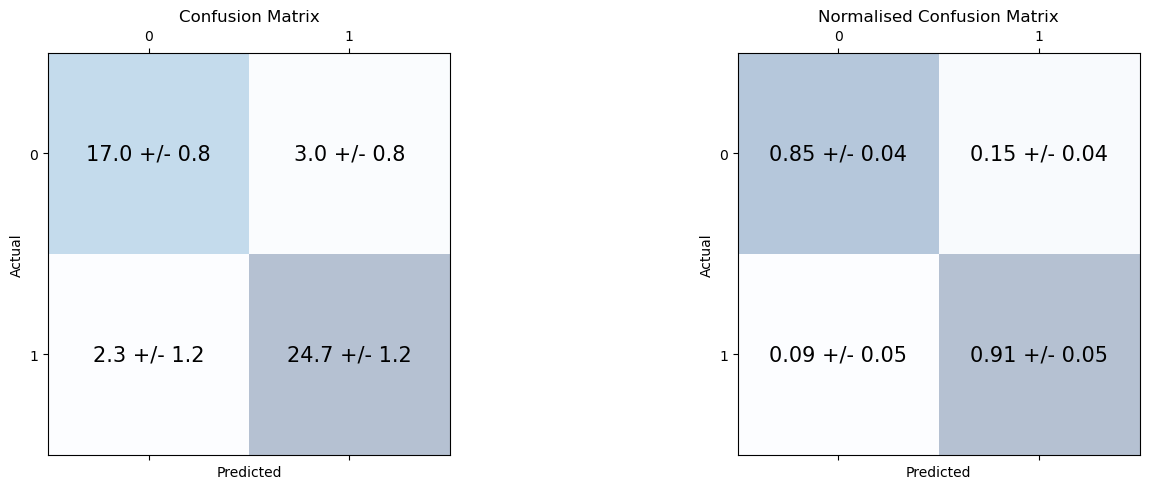

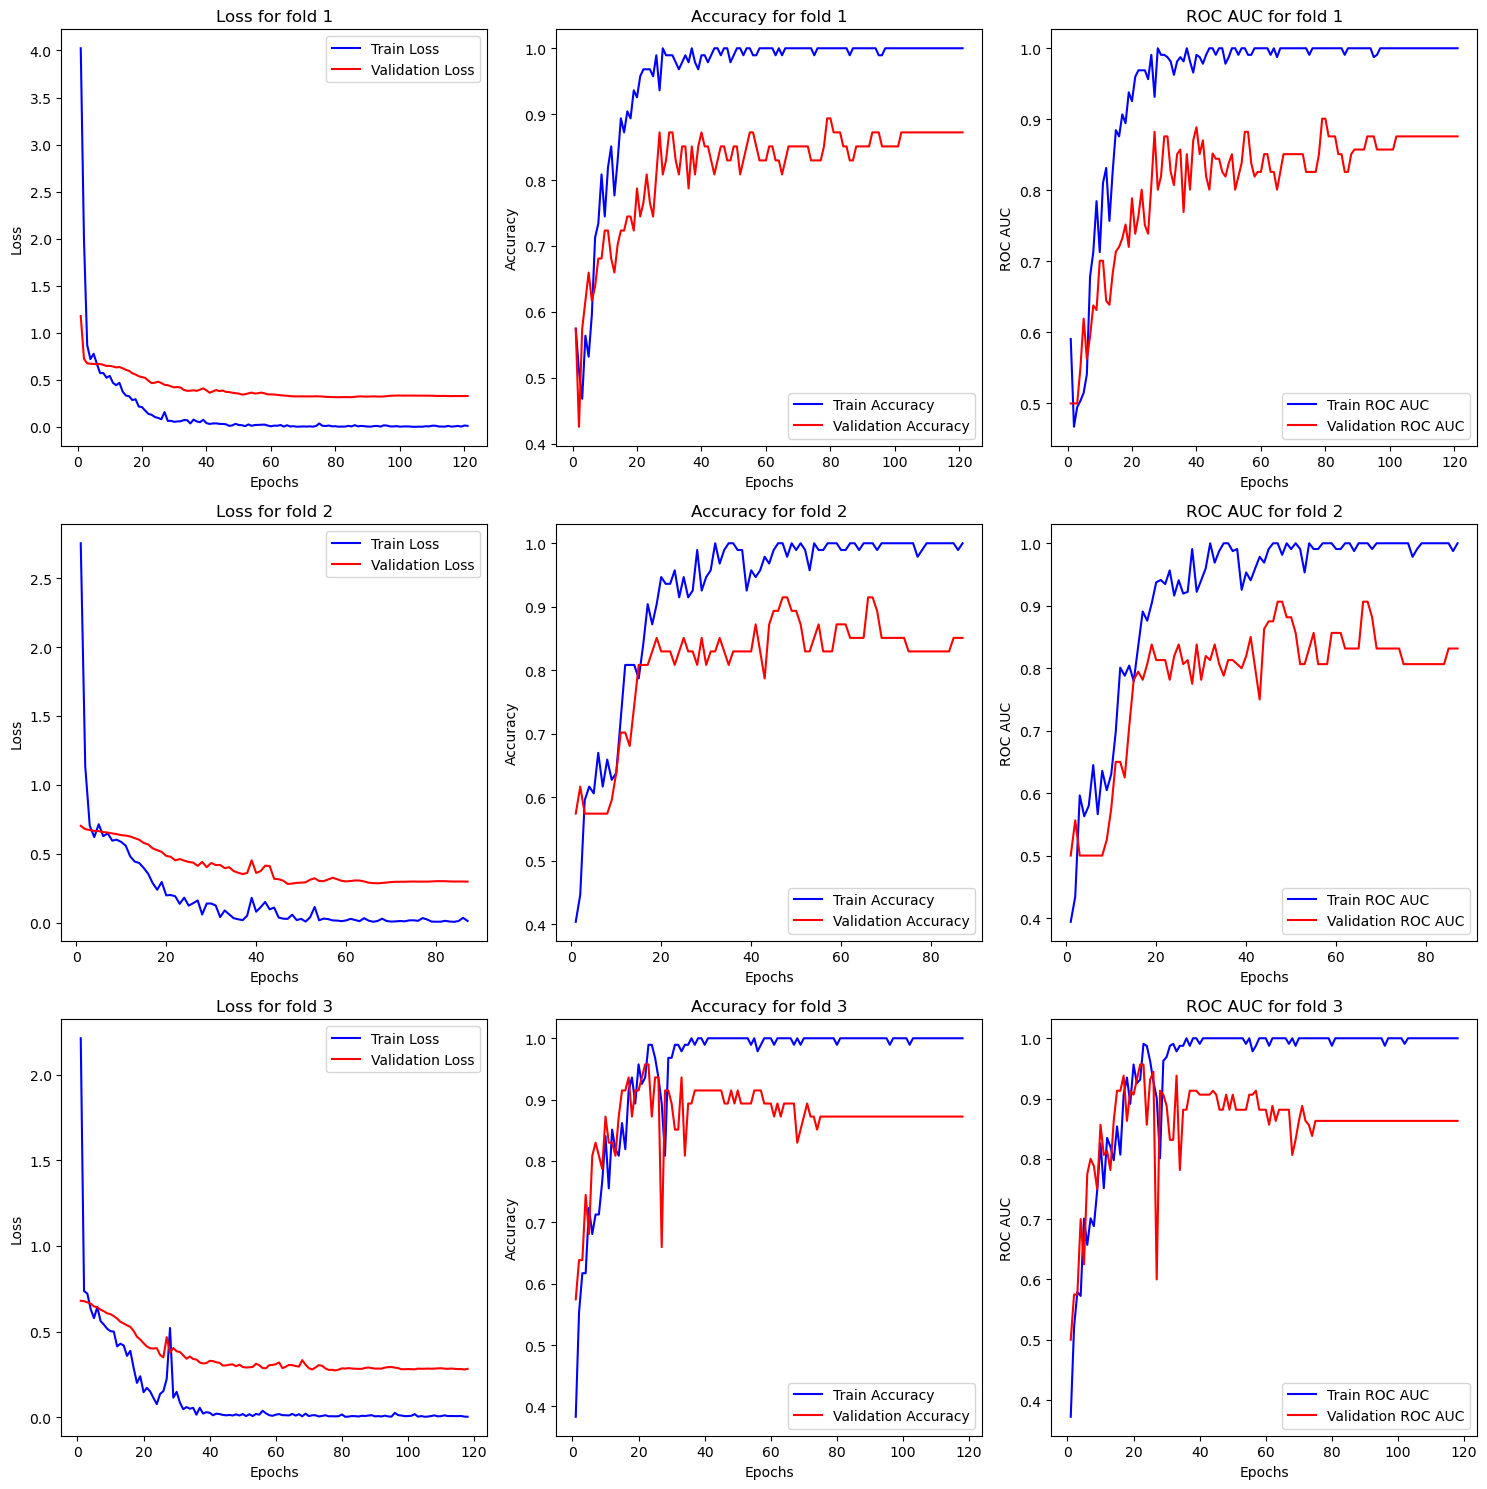

In [109]:
print_val_results(results)
plot_confusion_matrix(results)
plot_results(results, FOLDS)

In [110]:
# test data
test_loader = DataLoader(test_graph_data, batch_size=1)

# load all 3 folds
model_paths = ["trained_models/Full_model_GAT_fold_1_rocauc_0.88.pt", "trained_models/Full_model_GAT_fold_2_rocauc_0.91.pt", "trained_models/Full_model_GAT_fold_3_rocauc_0.86.pt"]
models = [ResGAT(train_graph_data[0].num_features, layer_configs, mlp_config, 2).to(device) for _ in range(3)]
for i, model in enumerate(models):
    model.load_state_dict(torch.load(model_paths[i]))

# get confusion matrix for each fold
confusion_matrices = []
for model in models:
    _, test_confusion_matrix = validate(test_loader, model, loss_fn, device, update_confusion_matrix=True)
    confusion_matrices.append(test_confusion_matrix)

# average confusion matrices
average_confusion_matrix = sum(confusion_matrices) / len(confusion_matrices)

recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, roc_auc = calculate_metrics(average_confusion_matrix)

print(f"Test Acc: {accuracy:.4f}, Test ROC_AUC: {roc_auc:.4f}, Test F1 Phen1: {f1_phen1:.4f}, Test F1 Phen2: {f1_phen2:.4f}")



Test Acc: 0.8750, Test ROC_AUC: 0.8135, Test F1 Phen1: 0.9183, Test F1 Phen2: 0.7342
